In [7]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq # root finding method
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

We use the black scholes equation:  
$C(S,T)=Se^{-qT}\phi{d_1}-Ke^{-rT}\phi{d_2}$  
where  
$d1=\frac{\text{ln}(\frac{S}{K})+(r-q+\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}$  
and  
$d2=d1-\sigma\sqrt{T}$

In [3]:
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

def implied_vol_call(C_mkt, S, K, T, r, q):
    # Root-finding with Brent’s method (robust)
    # returns IV (sigma) such that f(sigma)=0
    try:
        return brentq(
            lambda sigma: black_scholes_call(S, K, T, r, q, sigma) - C_mkt,
            1e-6, 5.0
        )
    except Exception as e:
        print('FAILED TO USE IMPLIED VOL CALL:', e)
        print('WITH VALUES:')
        print('Cmrkt:', C_mkt); print('S:', S); print('K:', K); print('T:', T); print('r and q:', r, q)
        raise

In [8]:
def GBM(S0=100, sigma=0.05, mu=0.1/365, start_time=datetime(2024, 1, 1), end_time=datetime(2024, 12, 1), dt=1/365,
        dt_date=timedelta(days=1)):
    """
    start_time and end_time must be datetime objects, and dt is a timedelta
    sigma is the fixed volatility
    mu is the average return (in unit of dt)
    sigma and mu must be per dt (years)
    dt is amount of years for each timestep (usually 1 day)
    """

    S = [S0]
    D = [start_time]
    while start_time + dt_date < end_time:
        s = S[-1]*np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*np.random.standard_normal())
        S.append(s)
        D.append(start_time)
        start_time += dt_date

    return pd.DataFrame({"Price": S}, index=D)

                 Price
2024-01-01  100.000000
2024-01-01  100.257991
2024-01-02  100.347819
2024-01-03  100.210639
2024-01-04   99.575624
...                ...
2024-11-25  103.273248
2024-11-26  103.377746
2024-11-27  103.694004
2024-11-28  103.420721
2024-11-29  103.649483

[335 rows x 1 columns]


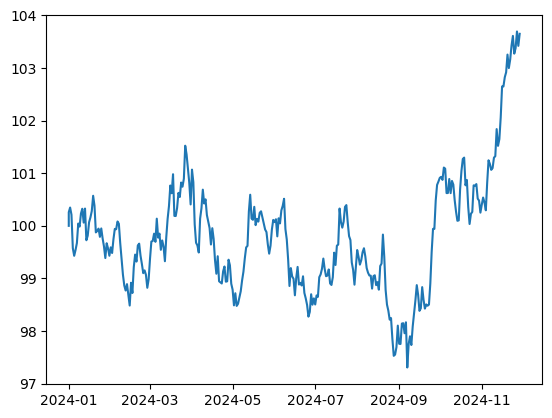

In [10]:
data = GBM()
print(data)
# plot simulated data

fig, ax = plt.subplots()

ax.plot(data.index, data["Price"])
plt.show()

In [11]:
def fluct_volatility_gbm(S0=100, V0=0.4,
                         mu=0.1/365, start_time=datetime(2024, 1, 1), end_time=datetime(2024, 12, 1), dt=1/365,
                         dt_date=timedelta(days=1),
                         kappa=0.1, theta=0.4, xi=0.4):
    """
    start_time and end_time must be datetime objects, and dt is a timedelta
    mu is the average return (in unit of dt)
    kappa is the rate of mean reversion (of volatility)
    theta is the long term average volatility
    xi is the volatility of volatility
    """
    S = [S0]
    D = [start_time]
    V = [V0]
    while start_time + dt_date < end_time:
        sigma = max(V[-1]+kappa*(theta-V[-1])*dt+xi*np.sqrt(V[-1])*np.random.standard_normal()*np.sqrt(dt), 0.1)
        V.append(sigma)
        s = S[-1]*np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*np.random.standard_normal())
        S.append(s)
        start_time += dt_date
        D.append(start_time)

    return pd.DataFrame({
        "Price": S,
        "Volatility": V
    }, index=D)

                 Price  Volatility
2024-01-01  100.000000    0.400000
2024-01-02   99.250097    0.412636
2024-01-03  100.299027    0.403154
2024-01-04  106.931573    0.396517
2024-01-05  110.678979    0.406935
...                ...         ...
2024-11-26   40.024230    0.613168
2024-11-27   38.961946    0.604748
2024-11-28   37.720064    0.608562
2024-11-29   37.851331    0.601817
2024-11-30   37.611754    0.570255

[335 rows x 2 columns]


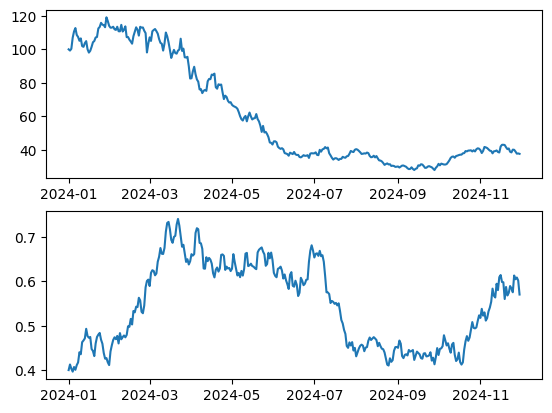

In [13]:
data = fluct_volatility_gbm()

print(data)

fig, (ax0, ax1) = plt.subplots(2)
ax0.plot(data.index, data["Price"])
ax1.plot(data.index, data["Volatility"])

plt.show()


In [14]:
def fluct_volatility_gbm_with_vol(S0=100, V0=0.05,
                         mu=0.1/365, start_time=datetime(2024, 1, 1), end_time=datetime(2024, 12, 1), dt=1/365,
                         dt_date=timedelta(days=1),
                         kappa=0.1, theta=0.2, xi=0.5,
                         mu_volume=5, sigma_volume=1):
    
    dsv = fluct_volatility_gbm(S0, V0, mu, start_time, end_time, dt, dt_date, kappa, theta, xi)
    vols = np.random.normal(mu_volume, sigma_volume, size=len(dsv))
    vols = np.clip(vols, 0.1, None)
    dsv["Volume"] = vols
    return dsv

                 Price  Volatility    Volume
2024-01-01  100.000000    0.050000  5.425035
2024-01-02   99.291398    0.100000  5.519238
2024-01-03   99.614242    0.100000  5.006826
2024-01-04   99.749696    0.104483  3.651926
2024-01-05   98.655058    0.107921  2.175473
...                ...         ...       ...
2024-11-26  102.017125    0.339612  4.324653
2024-11-27  103.631207    0.338866  4.560305
2024-11-28  104.922808    0.343607  4.480012
2024-11-29   99.081187    0.368964  5.435622
2024-11-30  100.397212    0.364053  6.198852

[335 rows x 3 columns]


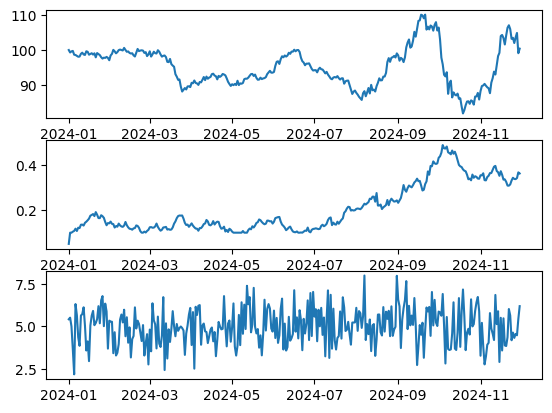

In [15]:
data = fluct_volatility_gbm_with_vol()

print(data)

fig, (ax0, ax1, ax2) = plt.subplots(3)
ax0.plot(data.index, data["Price"])
ax1.plot(data.index, data["Volatility"])
ax2.plot(data.index, data["Volume"])

plt.show()

In [23]:

def option_data_sim(
                exp_dates=[datetime(2025, m, 1) for m in range(1, 3)],
                snapshot_start=datetime(2024, 1, 1),
                snapshot_end=datetime(2024, 12, 1),
                snapshot_dt=timedelta(days=1),
                dt=1/365,
                dt_adding_contracts=timedelta(weeks=8),
                strike_std_pct=0.05,
                num_strikes_mean=5,
                num_strikes_std=2,
                r=0.03,
                q=0.0,
                mu_volume=50,
                sigma_volume=5,
                volume_dv_p=0.0,
                iv_alpha=0.5
                ):

    dpv = fluct_volatility_gbm_with_vol(start_time=snapshot_start, end_time=snapshot_end, dt_date=snapshot_dt, dt=dt)

    snapshot_time = snapshot_start

    asset_price = dpv.loc[snapshot_time, "Price"]
    asset_vola = dpv.loc[snapshot_time, "Volatility"]
    asset_volume = dpv.loc[snapshot_time, "Volume"]

    D = [] # data unit, stores windows for every expiry date, copy gets appended to snapshots
    
    # initialize first few contracts (for every expiry date)

    snapshots = []

    for expdate in exp_dates:

        num_strikes = round(np.random.normal(num_strikes_mean, num_strikes_std))

        strike_prices = np.random.normal(asset_price, asset_price*strike_std_pct, num_strikes)
        prices = black_scholes_call(
            np.full(num_strikes, asset_price),
            strike_prices,
            np.full(num_strikes, (expdate-snapshot_time).days/365),
            np.full(num_strikes, r),
            np.full(num_strikes, q),
            np.full(num_strikes, asset_vola)
        )
        args = [
            (pr, asset_price, spr, (expdate-snapshot_time).days/365, r, q)
            for pr, spr in zip(prices, strike_prices)
        ]
        # with Pool(N_SUBPROCESSES) as pool:
        #     ivs = pool.starmap(implied_vol_call, args)
        ivs = [implied_vol_call(*ai) for ai in args]

        moneynesses = strike_prices / asset_price

        volumes = np.round(np.random.normal(mu_volume, sigma_volume, num_strikes))
        k = np.array([
                strike_prices,
                ivs,
                prices,
                volumes,
                moneynesses
                ]).T
        
        D.append(k)


        
    snapshots.append({
        "time": snapshot_time,
        "assetprice": asset_price,
        "assetvolume": asset_volume,
        "assetvolatility": asset_vola,
        "data": [{"expdate": ed, "table": pd.DataFrame(k, columns=[
            "strike", "iv", "price", "volume", "moneyness"
            ])} for ed,k in zip(exp_dates, D)]
        })
    

    snapshot_time += snapshot_dt

    while snapshot_time < snapshot_end:

        cum_new_contracts_dt = snapshot_start
        asset_price = dpv.loc[snapshot_time, "Price"]
        asset_vola = dpv.loc[snapshot_time, "Volatility"]
        asset_volume = dpv.loc[snapshot_time, "Volume"]

        new_contracts = (snapshot_time - cum_new_contracts_dt).total_seconds() >= dt_adding_contracts.seconds

        for i,expdate in enumerate(exp_dates):
        
            # update volume, iv and price of existing contracts

            n = D[i].shape[0]
            strike_prices = D[i][:,0]
            moneynesses = strike_prices / asset_price
            sample_volas = asset_vola*(1+iv_alpha*(moneynesses-1))
            prices = black_scholes_call(
                np.full(n, asset_price),
                strike_prices,
                np.full(n, (expdate-snapshot_time).days/365),
                np.full(n, r),
                np.full(n, q),
                sample_volas
            )
            args = [
                (pr, asset_price, spr, (expdate-snapshot_time).days/365, r, q)
                for pr, spr in zip(prices, strike_prices)
            ]

            ivs = [implied_vol_call(*ai) for ai in args]

            D[i][:,3] = np.round(D[i][:,3] * np.random.normal(moneynesses, moneynesses * volume_dv_p))
            D[i][:,1] = ivs
            D[i][:,4] = moneynesses
            D[i][:,2] = prices

            if new_contracts:

                # add one new contract
                strike_price = np.random.normal(asset_price, asset_price*strike_std_pct)
                sample_vola = asset_vola*(1+iv_alpha*(strike_price/asset_price-1))
                price = black_scholes_call(asset_price, strike_price, (expdate-snapshot_time).days/365, r=r, q=q, sigma=sample_vola)
                iv = implied_vol_call(price, asset_price, strike_price, (expdate-snapshot_time).days/365, r=r, q=q)
                volume = np.random.normal(mu_volume, sigma_volume)
                moneyness = strike_price / asset_price

                cum_new_contracts_dt = snapshot_time

                l = np.array([
                    strike_price,
                    iv,
                    price,
                    volume,
                    moneyness
                ]).T
                D[i] = np.vstack([D[i], l])
        
        snapshot_time += snapshot_dt

        snapshots.append({
        "time": snapshot_time,
        "assetprice": asset_price,
        "assetvolume": asset_volume,
        "assetvolatility": asset_vola,
        "data": [{"expdate": ed, "table": pd.DataFrame(k, columns=[
            "strike", "iv", "price", "volume", "moneyness"
            ])} for ed,k in zip(exp_dates, D)]
        })
    return dpv, snapshots

time: 2024-01-01 00:00:00
time: 2024-01-03 00:00:00
time: 2024-01-04 00:00:00
time: 2024-01-05 00:00:00
time: 2024-01-06 00:00:00
time: 2024-01-07 00:00:00
time: 2024-01-08 00:00:00
time: 2024-01-09 00:00:00
time: 2024-01-10 00:00:00
time: 2024-01-11 00:00:00
time: 2024-01-12 00:00:00
time: 2024-01-13 00:00:00
time: 2024-01-14 00:00:00
time: 2024-01-15 00:00:00
time: 2024-01-16 00:00:00
time: 2024-01-17 00:00:00
time: 2024-01-18 00:00:00
time: 2024-01-19 00:00:00
time: 2024-01-20 00:00:00
time: 2024-01-21 00:00:00
time: 2024-01-22 00:00:00
time: 2024-01-23 00:00:00
time: 2024-01-24 00:00:00
time: 2024-01-25 00:00:00
time: 2024-01-26 00:00:00
time: 2024-01-27 00:00:00
time: 2024-01-28 00:00:00
time: 2024-01-29 00:00:00
time: 2024-01-30 00:00:00
time: 2024-01-31 00:00:00
time: 2024-02-01 00:00:00
time: 2024-02-02 00:00:00
time: 2024-02-03 00:00:00
time: 2024-02-04 00:00:00
time: 2024-02-05 00:00:00
time: 2024-02-06 00:00:00
time: 2024-02-07 00:00:00
time: 2024-02-08 00:00:00
time: 2024-0

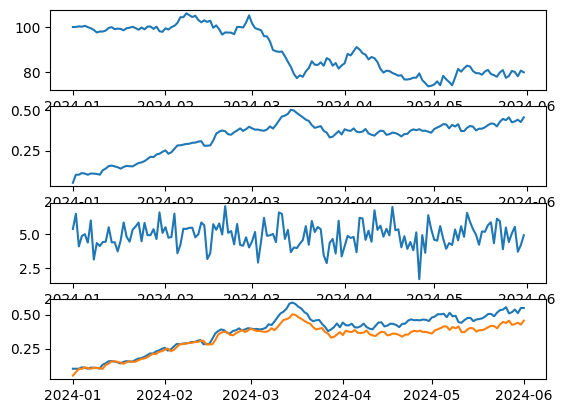

In [25]:
asset_data, options = option_data_sim(
    snapshot_start=datetime(2024, 1, 1),
    snapshot_end=datetime(2024, 6, 1),
    snapshot_dt=timedelta(days=1),
)

fig, ax = plt.subplots(4)

ivs = []
hvs = []
dates = []

for t in options:
    print('time:', t["time"])
    e = t["data"][0]
    expdate = e["expdate"]
    c = e["table"]
    iv = (c["iv"] * c["volume"]).sum() / c["volume"].sum()
    ivs.append(iv)
    hvs.append(t["assetvolatility"])
    dates.append(t["time"])

    
ax[0].plot(asset_data.index, asset_data["Price"])
ax[1].plot(asset_data.index, asset_data["Volatility"])
ax[2].plot(asset_data.index, asset_data["Volume"])
ax[3].plot(dates, ivs)
ax[3].plot(dates, hvs)
plt.show()